In [ ]:
!pip install datasets seqeval
!pip install tensorflow

In [ ]:
from datasets import load_dataset
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
import matplotlib.pyplot as plt

In [ ]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")

In [ ]:
# Extract training and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Convert Hugging Face format to lists
train_sentences = [[word for word in sentence['tokens']] for sentence in train_data]
train_labels = [[label for label in sentence['ner_tags']] for sentence in train_data]
test_sentences = [[word for word in sentence['tokens']] for sentence in test_data]
test_labels = [[label for label in sentence['ner_tags']] for sentence in test_data]

In [ ]:
# Create mappings
unique_labels = set(label for sublist in train_labels for label in sublist)
label2idx = {label: i for i, label in enumerate(unique_labels)}
idx2label = {i: label for label, i in label2idx.items()}

In [ ]:
# Define max sentence length
max_len = 75

# Convert words to indices
word2idx = {word: i + 2 for i, word in enumerate(set(word for sentence in train_sentences for word in sentence))}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {i: word for word, i in word2idx.items()}

In [ ]:
# Pad and encode sequences
X_train = pad_sequences([[word2idx.get(w, 1) for w in s] for s in train_sentences], maxlen=max_len, padding="post")
X_test = pad_sequences([[word2idx.get(w, 1) for w in s] for s in test_sentences], maxlen=max_len, padding="post")

y_train = pad_sequences([[label2idx[t] for t in ts] for ts in train_labels], maxlen=max_len, padding="post", value=label2idx[0])
y_test = pad_sequences([[label2idx[t] for t in ts] for ts in test_labels], maxlen=max_len, padding="post", value=label2idx[0])

y_train = [to_categorical(i, num_classes=len(label2idx)) for i in y_train]
y_test = [to_categorical(i, num_classes=len(label2idx)) for i in y_test]

In [ ]:
# Build and train model (same as before)
def build_model():
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=len(word2idx), output_dim=50, input_length=max_len)(input)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    model = TimeDistributed(Dense(len(label2idx), activation="relu"))(model)
    model = keras.Model(input, model)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 75, 50)              │       1,181,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 75, 9)               │           1,809 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,303,859 (4.97 MB)

 Trainable params: 1,303,859 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 166s 351ms/step - accuracy: 0.9531 - loss: nan - val_accuracy: 0.9688 - val_loss: nan
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 192s 329ms/step - accuracy: 0.9676 - loss: nan - val_accuracy: 0.9688 - val_loss: nan
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 147s 334ms/step - accuracy: 0.9679 - loss: nan - val_accuracy: 0.9688 - val_loss: nan
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - accuracy: 0.9675 - loss: nan - val_accuracy: 0.9688 - val_loss: nan
Epoch 4: early stopping


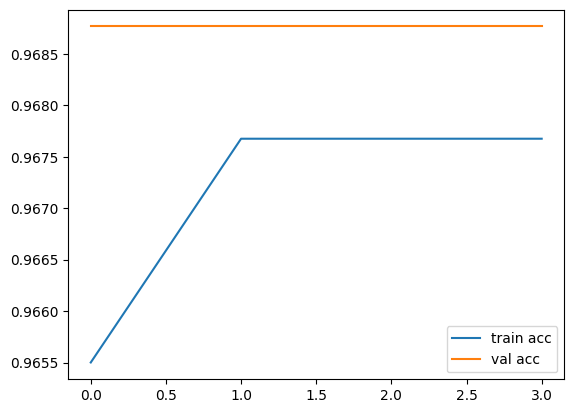

In [ ]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)

history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_test, np.array(y_test)),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluate and visualize results
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

In [2]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

In [ ]:
# Install the required libraries
!pip install streamlit tensorflow datasets

# Save your Streamlit app code to a Python file (app.py)
with open('app.py', 'w') as f:
    f.write("""
import streamlit as st
import numpy as np
import tensorflow as tf
from datasets import load_dataset

# Load the dataset
@st.cache_data
def load_data():
    dataset = load_dataset("conll2003", trust_remote_code=True)
    return dataset

if __name__ == "__main__":
    dataset = load_data()

    st.title("Named Entity Recognition (NER) using CoNLL-2003 Dataset")

    # Extract training data
    train_data = dataset["train"]
    test_data = dataset["test"]

    # Convert to lists
    train_sentences = [[word for word in sentence['tokens']] for sentence in train_data]
    train_labels = [[label for label in sentence['ner_tags']] for sentence in train_data]

    test_sentences = [[word for word in sentence['tokens']] for sentence in test_data]
    test_labels = [[label for label in sentence['ner_tags']] for sentence in test_data]

    st.write("### Sample Training Sentence")
    st.write(" ".join(train_sentences[0]))
    st.write("### Corresponding Labels")
    st.write(train_labels[0])

    # Placeholder for model training logic
    st.write("## Model Training Coming Soon...")
""")

# Now, use the following to run the Streamlit app in Colab
!streamlit run app.py & npx localtunnel --port 8501




⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.237.189.189:8501

⠼⠴⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 